# What drives Zestimate LogError?

### Project Goals
* Identify key features that can be used to create an effective predictive model
* Use features to develop a machine learning model that predicts the Zestimate LogErrors

## Imports

In [1]:
#imports needed for this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#modules created for this report
import wrangle as w
#import explore as e
#import model as m

### Acquire

* Data acquired from the Codeup mySQL server
* Contained 52205 rows and 15 columns
* Each row represents an individual parcel
* Each column represents a feature of that parcel

In [2]:
#import raw data from Codeup mySQL server
zillow_unclean = w.acquire_zillow_data()

In [3]:
zillow_unclean.shape

(52205, 15)

### Prepare

#### Actions:


* Removed nulls in the data
    * For ```fireplace```, ```deck```, ```pool```, ```garage```, and ```hottub``` NULL values were converted to "0"
    * Rows containing null values in any column (< 1% dropped)
    
* Renamed columns to promote readability
    * ```county``` (names based on the fips code):  
        - 6037: LA
        - 6059: Orange 
        - 6111: Ventura 

    * ```2017_age```
        - Column displaying age of house in 2017 (2017-year_built)

* Split data into train, validate, and test (65/20/15)


***51843 rows before splitting*** 

In [4]:
#clean data
zillow = w.clean_zillow(zillow_unclean)
zillow.shape

(51843, 15)

In [5]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51843 entries, 0 to 52204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   parcelid           51843 non-null  int64  
 1   logerror           51843 non-null  float64
 2   bathrooms          51843 non-null  float64
 3   bedrooms           51843 non-null  int64  
 4   sqft               51843 non-null  int64  
 5   latitude           51843 non-null  float64
 6   longitude          51843 non-null  float64
 7   lotsizesquarefeet  51843 non-null  int64  
 8   fireplace          51843 non-null  int64  
 9   deck               51843 non-null  int64  
 10  pool               51843 non-null  int64  
 11  garage             51843 non-null  int64  
 12  hottub             51843 non-null  int64  
 13  county             51843 non-null  object 
 14  2017_age           51843 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 6.3+ MB


In [6]:
#split data
train, validate, test = w.split_data(zillow)

### Data Dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
|**parcelid**|  Unique identifier for parcels (lots) | *int*|
| **bathroooms** |  Number of bathrooms in home |*float*|
| **bedrooms** | Number of bedrooms in home |*int*|
|**sqft**| Area of home in square feet | *int*|
|**year_built**| Year home was built| *int*|
|**latitude**| Latitude of the middle of the parcel | *float*|
|**longitude**| Longitude of the middle of the parcel | *float*|
|**lotsizesquarefeet**|  Area of the lot in square feet | *float*|
|**fireplace**| Number of fireplaces in home | *float*|
|**deck**| Number of decks in home | *float*|
|**pool**| Number of pools in home | *float*|
|**garage**| Number of garages in home | *float*|
|**hottub**| Number of hottubs in home | *float*|
|**county**| County where the home is located | *string*|
|**2017_age**| Age of the home as of 2017 | *int*|
|**Target Variable**
|**logerror**| 𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒) | *float* |

### A look at the data

In [7]:
#show the first few rows of the train data
train.head()

,parcelid,logerror,bathrooms,bedrooms,sqft,latitude,longitude,lotsizesquarefeet,fireplace,deck,pool,garage,hottub,county,2017_age
46729,11669351,0.037351,4.0,4,3470,34045821.0,-118517058.0,7148,0,0,0,0,0,LA,12
47582,13844703,-0.103982,1.0,3,999,33728543.0,-117879618.0,6716,0,0,1,1,1,Orange,67
32610,14110023,0.042899,3.0,5,1803,33825991.0,-118045155.0,6203,0,0,0,1,1,Orange,53
22180,11703748,-0.002878,1.0,2,1586,34001625.0,-118304436.0,5867,0,0,0,0,0,LA,105
28282,13899266,0.166119,1.0,2,902,33427590.0,-117617406.0,4600,0,0,0,1,1,Orange,57


## Explore

### What is the distribution of LogError by county?

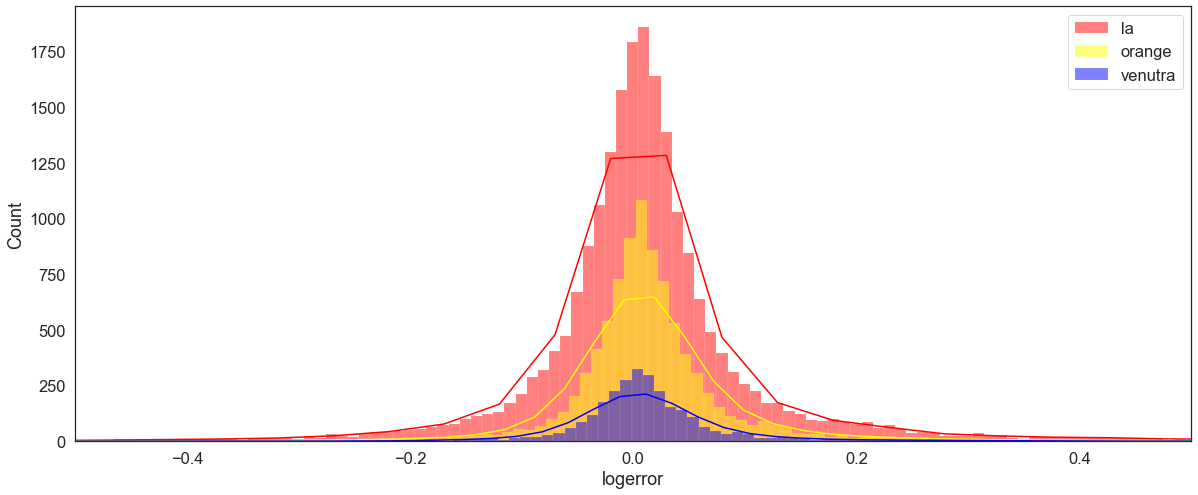

In [8]:
#font size
sns.set(font_scale=1.5)
#plot style
sns.set_style('white')
fig, ax = plt.subplots(1,1, figsize=(20,8))

sns.histplot(train[train.county=='LA'].logerror, kde=True, ax=ax, binwidth=.01, color='red', label='la')
sns.histplot(train[train.county=='Orange'].logerror, kde=True, ax=ax, binwidth=.01,color ='yellow', label='orange')
sns.histplot(train[train.county=='Ventura'].logerror, kde=True, ax=ax, binwidth=.01, color='blue', label='venutra')
ax.set_xlim(-0.5,0.5)
ax.legend()
plt.show()

**Logerror is normally distributed** 

Our initial hypothesis was that in comparison to the largest county being LA, would show a significant difference in the LogError distribution.

What we discovered is that the LogErrors were very similar in their distribution for each county.

In [9]:
# If they have a deck and fireplace strong strong correlation to log error 
# pool has no effect

In [10]:
# cluster 1 fireplace and deck vs logerror


In [11]:
# sqft of structure- all counties have less log error after 5000sqft
# lotsize - all counties have less log error after 30000sqft

In [12]:
# sqt/ lot feature clustering shows not much variance,
# amongst the 7 centroids verse log error. 4th centroid shows min logerror
# upon we see huge lots size small house. not usable, 

In [9]:
train_scale, validate_scale, test_scale =w.scale_zillow(train, validate, test, 'logerror')

### Modeling Features

In [10]:
special_features_cluster1 = train_scale[['pool','deck','garage','hottub','fireplace']]

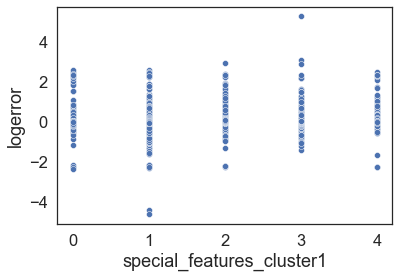

In [12]:
#Fit a new model to my scaled data
kmeans_scale = KMeans(n_clusters=5)

kmeans_scale.fit(special_features_cluster1)

train['special_features_cluster1'] = kmeans_scale.predict(special_features_cluster1)
sns.scatterplot(y='logerror', x='special_features_cluster1',
        palette='colorblind', data=train_scale)
plt.show()

In [13]:
cluster0 = train[train['special_features_cluster1'] ==0].logerror
cluster1 = train[train['special_features_cluster1'] ==1].logerror
cluster2 = train[train['special_features_cluster1'] ==2].logerror
cluster3 = train[train['special_features_cluster1'] ==3].logerror
cluster4 = train[train['special_features_cluster1'] ==4].logerror

In [14]:
stats.kruskal(cluster0,cluster1,cluster2,cluster3,cluster4)

KruskalResult(statistic=85.32376808887317, pvalue=1.2950354111524735e-17)

### 2. Is there a significant relationship between sqft and logerror? 

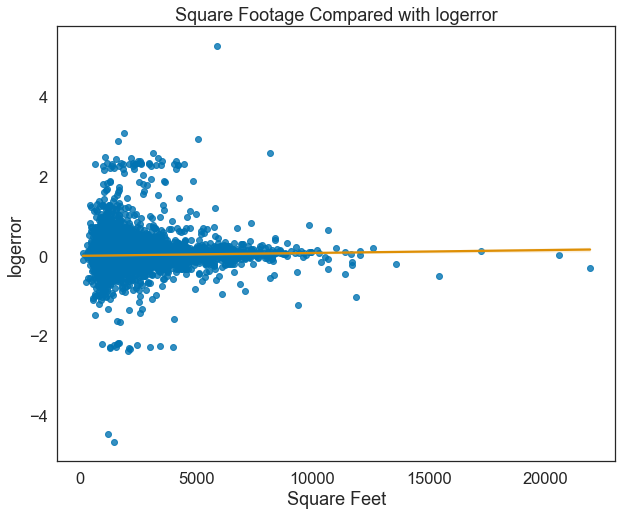

In [9]:
#set font size
sns.set(font_scale=1.5)
#set plot style
sns.set_style('white')

#make plot
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.regplot('sqft', 'logerror', data=train, scatter_kws={"color":"#0173b2"}, line_kws={"color": "#de8f05"})
ax.set_title("Square Footage Compared with logerror")
ax.set_xlabel("Square Feet")
ax.set_ylabel("logerror")
plt.show()

**It looks like there is a linear correlation between bath_bed_ratio and home value *AND a pesky outlier***

**Set Hypothesis**

$H_0$ = There is no linear correlation between sqft and logerror 

$H_a$ = There is a linear correlation between sqft and logerror 

In [10]:
 #run spearman test to see if there is any linear correlation
corr, p = stats.spearmanr(train.sqft, train.logerror)

#print results
print(f"Correlation Coefficient: {corr:.2}\np-value: {p:.4}")

Correlation Coefficient: 0.079
p-value: 9.264e-48


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between square footage and logerror.** 

## 3. Does location have a relationship with home value?

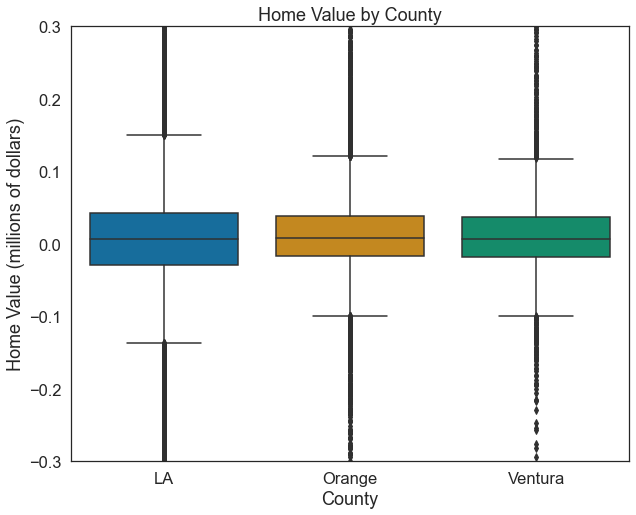

In [11]:
#make plot
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.boxplot(data = train, x = 'county', y = 'logerror', palette='colorblind', ax=ax)
ax.set_title('Home Value by County')
ax.set_xlabel('County')
ax.set_ylabel('Home Value (millions of dollars)')
ax.set_ylim(-.3,.3)
plt.show()

**It looks like there is a difference in home values in each county.**

$H_0$ = Average logerror of those in LA county, Orange county and Ventura county are the same.

$H_a$ = Average logerror of those in LA county, Orange county and Ventura county are not the same.

In [12]:
#splitting data into a df per county:
la = train[train.county == 'LA'].logerror
orange = train[train.county == 'Orange'].logerror
ventura = train[train.county == 'Ventura'].logerror

#Running a one-way ANOVA (there is a single independent variable - 'county'):
f, p = stats.kruskal(la, orange, ventura)

#print results
print(f"F-score: {f:.8}\np-value: {p:.4}")

F-score: 40.504427
p-value: 1.602e-09


**Since p < alpha we can reject the null hypothesis and say Average logerror of those in LA county, Orange county and Ventura county are not the same.**

## 4. Is there a significant relationship between age of the home and home value?

**It looks like there is a linear correlation between ?????? and logerror**

**Set Hypothesis**

$H_0$ = There is no linear correlation between ?????? and logerror 

$H_a$ = There is a linear correlation between ?????? and logerror

In [13]:
#run spearmanr test and show results
#e.age_spearmanr(train)

**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between 2017_age and home value.** 

### Exploration Summary
* ```square_feet``` has the highest correlation coefficient so I will use it in my model.
* ```bed_bath_ratio```, ```2017_age```, and ```county``` all show a relationship with home value so I will also take them to my model.

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|**square_feet**| From our Spearman's test we saw that the correlation coefficient is 0.48 between ```square_feet``` and ```home_value```|
|**bath_bed_ratio**| From our Spearman's test we saw that the correlation coefficient is 0.32 between ```bath_bed_ratio``` and ```home_value```|
|**2017_age**| From our Spearman's test we saw that the correlation coefficient is 0.27 between ```2017_age``` and ```home_value```|
|**county**| From our ANOVA test we see that there is a difference between the home values in each county|

In [14]:
#save drivers into a list
drivers = ['sqft', '2017_age', 'county']

### Features I'm not moving on with

| Feature | Reason 
|:--------|:-----------
|**parcelid**| id number that is not needed in the model
| **bathroooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
| **bedrooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
|**year_built**| Represented in the ```2017_age``` so it would be redundant.

# Modeling

### Prep for modeling
* I scaled the drivers using the minmax scaler
* Split the data into where ```home_value``` is the target variable

In [15]:
#prepare data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = w.prep_for_model(train, validate, test, 'logerror', drivers)

### Baseline models
* Looked at both using mean and median as a baseline model.
* Mean baseline performed better on the in-sample and out-of sample data SO I went with mean.

In [18]:
import sklearn.metrics as metric

def baseline_models(y_train, y_validate):
    '''
    Takes in y_train and y_validate and returns a df of 
    baseline_mean and baseline_median and how they perform
    '''
    train_predictions = pd.DataFrame(y_train)
    validate_predictions = pd.DataFrame(y_validate)
    
    y_pred_mean = y_train.mean()
    train_predictions['y_pred_mean'] = y_pred_mean
    validate_predictions['y_pred_mean'] = y_pred_mean
    
    y_pred_median = y_train.median()
    train_predictions['y_pred_median'] = y_pred_median
    validate_predictions['y_pred_median'] = y_pred_median

    # create the metric_df as a blank dataframe
    metric_df = pd.DataFrame(data=[
    {
        'model': 'mean_baseline', 
        'RMSE_train': metric.mean_squared_error(
            y_train,
            train_predictions['y_pred_mean']) ** .5,
        'RMSE_validate': metric.mean_squared_error(
            y_validate,
            validate_predictions['y_pred_mean']) ** .5,
        'Difference': (( metric.mean_squared_error(
            y_train,
            train_predictions['y_pred_mean']) ** .5)-(metric.mean_squared_error(
            y_validate,
            validate_predictions['y_pred_mean']) ** .5))
    }])

    return metric_df.append(
            {
                'model': 'median_baseline', 
                'RMSE_train': metric.mean_squared_error(
                    y_train,
                    train_predictions['y_pred_median']) ** .5,
                'RMSE_validate': metric.mean_squared_error(
                    y_validate,
                    validate_predictions['y_pred_median']) ** .5,
                'Difference': (( metric.mean_squared_error(
                    y_train,
                    train_predictions['y_pred_median']) ** .5)-(metric.mean_squared_error(
                    y_validate,
                    validate_predictions['y_pred_median']) ** .5))
            }, ignore_index=True)

In [19]:
baseline_models(y_train, y_validate)

,model,RMSE_train,RMSE_validate,Difference
0,mean_baseline,0.174556,0.18238,-0.007824
1,median_baseline,0.174886,0.18275,-0.007864


### Model Comparison

In [ ]:
#run and compare models
#m.regression_models(X_train, y_train, X_validate, y_validate)

### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* It was interesting that OLS Regressor and Lasso Lars both performed better on the out-of-sample data.

### Best model: Random Forest Model 
* I chose the XXX (XXXXXXXXXX) because the difference in $RMSE$ between the train and validate was around  and they were both higher than the other models
* I will now run the that model on test data to gauge how it will perform on future data

In [ ]:
#m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

## Conclusion

### Summary
*


### Recommendations
* We should do more research .
* .

### Next Steps
* In the next iteration:
    * 